Possible improvements to my work:-

1)Use Transfer Learning :-Create languege model first via transfer learning (using weights of Wikitext 103) and them fine tune this model with the Text of both Train and Validation sets. After that, use this Languege model to classify the text.

2) Proper hyperparameter tuning, which include adding more dense layers and changing the batchsize, changing the lenght of the dictionary and maxlength allowed for each text

**CODE STARTS FROM HERE**

Import the standard Keras library

In [117]:
import sys, os, re, csv, codecs, numpy as np, pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers
from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from sklearn.metrics import confusion_matrix

from tensorflow import keras
layers = keras.layers
models = keras.models

In [118]:
train = pd.read_csv("../input/trainin/train.csv")
test = pd.read_csv('../input/validation/valid.csv')

Checking for any null values in the train dataset

In [119]:
train.isnull().any(),test.isnull().any()


(Section    False
 Label      False
 dtype: bool, Section    False
 Label      False
 dtype: bool)

In [120]:
train.head()

,Section,Label
0,Description ÛÏJacobs National Security Soluti...,3
1,Duties will include Applying complex analysis ...,5
2,Job Qualifications Active Top Secret security ...,6
3,Essential Functions,5
4,Other Essential Functions Must be able to comm...,5


In [121]:
list_sentences_train=train["Section"]
list_sentences_test=test['Section']
y=train['Label']

In [122]:
# Use sklearn utility to convert label strings to numbered index
encoder = LabelEncoder()
encoder.fit(y)
y= encoder.transform(y)

In [123]:
num_classes = np.max(y) + 1
y = keras.utils.to_categorical(y, num_classes)

Below we tokenize the words in the sentences with a maximum length of 20000 of the dictionary 

In [124]:
max_features = 20000
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(list_sentences_train))
list_tokenized_train = tokenizer.texts_to_sequences(list_sentences_train)
list_tokenized_test = tokenizer.texts_to_sequences(list_sentences_test)

In [125]:
totalNumWords = [len(one_comment) for one_comment in list_tokenized_train]

Plotting the distribution of the number of words in sentences.

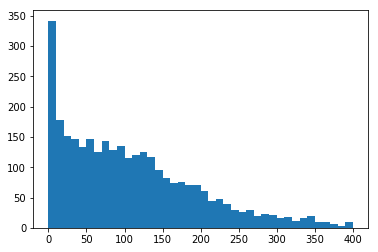

In [126]:
plt.hist(totalNumWords,bins = np.arange(0,410,10))
plt.show()

As we can see, most of the sentence length is about 150+.

In [134]:
maxlen = 200
X_t = pad_sequences(list_tokenized_train, maxlen=maxlen)
X_te = pad_sequences(list_tokenized_test, maxlen=maxlen)

Making Functions for recall, precision and F1 score as these are not available as metrics in Keras Models

In [135]:
from keras import backend as K

def recall_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

def precision_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

Defining the model architecture of the model which includes the embedding layer in the beginning followed by the LSTM unit followed by few dense units along with the dropouts

In [136]:
inp = Input(shape=(maxlen, )) #maxlen=150 as defined earlier
embed_size = 128
x = Embedding(max_features, embed_size)(inp)
x = LSTM(60, return_sequences=True,name='lstm_layer')(x)
x = GlobalMaxPool1D()(x)
x = Dropout(0.1)(x)
x = Dense(50, activation="relu")(x)
x = Dropout(0.1)(x)
x = Dense(9, activation="sigmoid")(x)
model = Model(inputs=inp, outputs=x)
model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['acc',f1_m,precision_m, recall_m])

We feed the output into a Sigmoid layer. The reason why sigmoid is used is because we are trying to achieve a binary classification(1,0) for each of the 9 labels, and the sigmoid function will squash the output between the bounds of 0 and 1.

In [137]:
batch_size = 64
epochs = 20
model.fit(X_t,y, batch_size=batch_size, epochs=epochs, validation_split=0.1)

Train on 2812 samples, validate on 313 samples
Epoch 1/20
2812/2812 [==============================] - 10s 3ms/step - loss: 0.5137 - acc: 0.7882 - f1_m: 0.0716 - precision_m: 0.1162 - recall_m: 0.1058 - val_loss: 0.3103 - val_acc: 0.8889 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 2/20
2812/2812 [==============================] - 9s 3ms/step - loss: 0.3112 - acc: 0.8849 - f1_m: 0.0661 - precision_m: 0.3493 - recall_m: 0.0377 - val_loss: 0.2965 - val_acc: 0.8889 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 3/20
2812/2812 [==============================] - 9s 3ms/step - loss: 0.3053 - acc: 0.8871 - f1_m: 0.0528 - precision_m: 0.3680 - recall_m: 0.0288 - val_loss: 0.2899 - val_acc: 0.8889 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 4/20
2812/2812 [==============================] - 9s 3ms/step - loss: 0.2963 - acc: 0.8857 - f1_m: 0.0590 - precision_m: 0.3362 - recall

Converting the labels in Validation dataset (named here as 'test')

In [138]:
y_test=test['Label']
encoder = LabelEncoder()
encoder.fit(y_test)
y_test= encoder.transform(y_test)
num_classes = np.max(y_test) + 1
y_test = keras.utils.to_categorical(y_test, num_classes)

Predicting for validation dataset (named as Test Dataset)

In [139]:
score = model.evaluate(X_te, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
print('Test F1:', score[2])
print('Test Precision:', score[3])
print('Test Recall:', score[4])

Test loss: 0.05675649005071739
Test accuracy: 0.9843704700469971
Test F1: 0.9293485879898071
Test Precision: 0.9435844421386719
Test Recall: 0.9162499904632568
